In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import lmfit as lm
import scipy.cluster.hierarchy as ch

In [2]:
egfp=scipy.io.loadmat('egfp.mat')
egfp0=egfp['egfp'][0][0].T
egfp1=egfp['egfp'][0][1].T
egfp2=egfp['egfp'][0][2].T
egfp3=egfp['egfp'][0][3].T
egfp4=egfp['egfp'][0][4].T
egfp5=egfp['egfp'][0][5].T
print(egfp0.shape)
print(egfp0[0])

(69, 87)
[    7.613     8.783     8.043     8.146     7.87     14.792    17.223
    18.214    50.67     86.331   128.749   178.647   282.779   347.294
   393.399   486.373   540.401   604.65    674.073   708.502   835.821
   968.104  1126.307  1246.89   1448.615  1615.209  1769.466  1989.18
  2062.952  2247.619  2568.201  2620.879  2844.773  2843.494  3010.477
  3145.863  3299.286  3456.149  3600.052  3754.178  3885.305  4007.221
  4155.592  4282.545  4381.757  4494.516  4684.44   4897.518  5068.585
  5160.991  4906.733  4844.889  5490.896  5603.009  5129.406  5303.168
  5639.464  5653.383  5458.522  5659.411  5636.559  5583.468  5548.399
  5750.172  5816.064  6112.156  6632.024  7354.074  7362.499  6280.564
  7545.685  7125.455  7421.587  7148.4    6970.323  6403.552  6138.144
  6293.732  6446.317  6515.006  6636.946  6594.705  6570.312  6689.705
  6709.791  6664.908  6627.534]


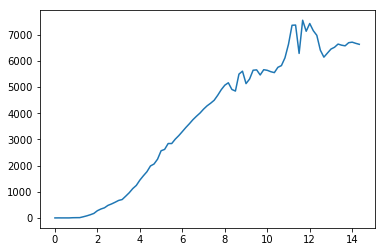

In [3]:
time = np.arange(0,egfp0[0].size)*10/60
plt.plot(time,egfp0[0])


In [4]:
def twostage(t,t0,km,delta,beta):
    km=np.abs(km)
    delta=np.abs(delta)
    beta=np.abs(beta)
    return (km/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))).clip(0)
twostage_model = lm.Model(twostage)

In [5]:
def threestage(t,t0,km,delta,beta):
    km=np.abs(km)
    delta=np.abs(delta)
    beta=np.abs(beta)
    dmb = delta-beta
    result = (km*((t-t0)/dmb + np.exp(-dmb*(t-t0))/dmb**2-1/dmb**2)*np.exp(-beta*(t-t0))).clip(0)
    result[t<t0]=0
    return result
threestage_model = lm.Model(threestage)

[[Model]]
    Model(twostage)
[[Fit Statistics]]
    # function evals   = 75
    # data points      = 87
    # variables        = 4
    chi-square         = 3606.041
    reduced chi-square = 43.446
    Akaike info crit   = 336.123
    Bayesian info crit = 345.986
[[Variables]]
    t0:      2.35701692 +/- 0.072203 (3.06%) (init= 7)
    km:      1104.14403 +/- 51.79020 (4.69%) (init= 800)
    delta:  -0.05115990 +/- 7.819862 (15285.14%) (init= 0.07)
    beta:    0.05121027 +/- 7.822525 (15275.30%) (init= 0.05)
[[Correlations]] (unreported correlations are <  0.100)
    C(delta, beta)               =  1.000 
    C(t0, km)                    =  0.728 
    C(km, beta)                  =  0.189 
    C(km, delta)                 =  0.188 

[[Model]]
    Model(threestage)
[[Fit Statistics]]
    # function evals   = 86
    # data points      = 87
    # variables        = 4
    chi-square         = 1464.892
    reduced chi-square = 17.649
    Akaike info crit   = 257.751
    Bayesian info crit =

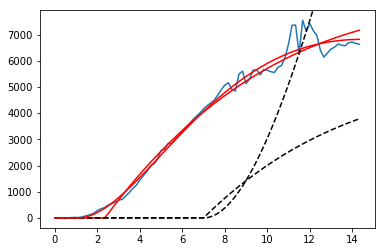

In [6]:
data = egfp0[0]
sigma = np.sqrt(data)
time = np.arange(0,data.size)*10/60
result2 = twostage_model.fit(data, t=time, t0=7, km=800, delta=0.07, beta=0.05, weights=1/sigma)
result3 = threestage_model.fit(data, t=time, t0=7, km=800, delta=0.07, beta=0.05, weights=1/sigma)
plt.figure()
plt.plot(time,data)
plt.plot(time,result2.init_fit, 'k--')
plt.plot(time, result2.best_fit, 'r-')
plt.plot(time,result3.init_fit, 'k--')
plt.plot(time, result3.best_fit, 'r-')
plt.ylim((-0.05*data.max(),data.max()*1.05))
print(result2.fit_report())
print(result3.fit_report())

In [7]:
# cluster analysis to find the onset for fluorescence
# normalize the data
time_norm=(time-time.min())/50/(time.max()-time.min())
t0cluster_list=[]
for data in egfp0:
    data_norm=(data-data.min())/(data.max()-data.min())
    data_diff_norm=np.gradient(data_norm)
    # combine the data
    X = np.vstack((time_norm,data_norm,data_diff_norm)).T
    # generate the linkage matrix
    Z = ch.linkage(X, method='single',metric='cityblock')
    tree = ch.cut_tree(Z, height=0.003).flatten()
    t0cluster_list.append(tree[tree==0].size)
t0cluster_list=np.array(t0cluster_list)
# convert to hours
t0cluster_list=(t0cluster_list)*10/60

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


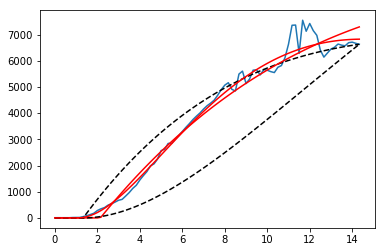

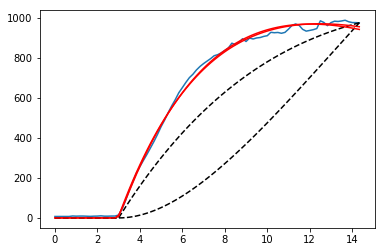

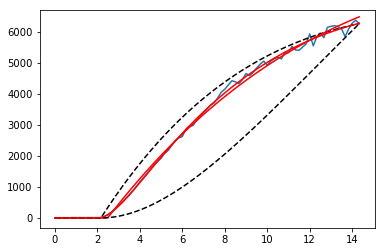

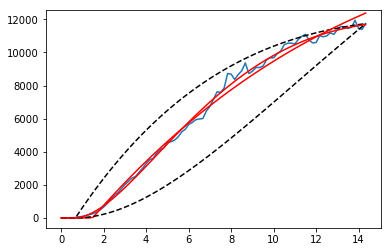

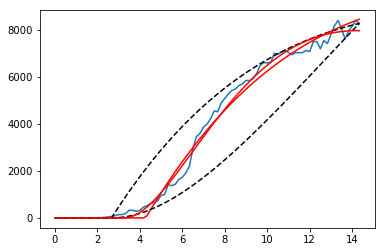

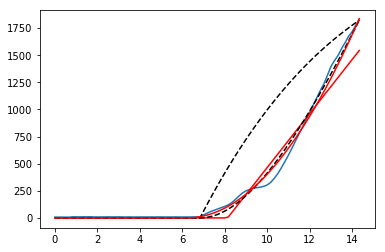

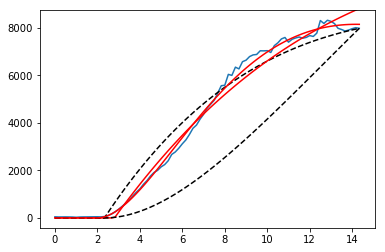

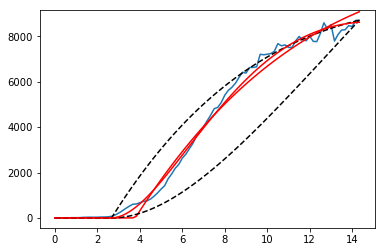

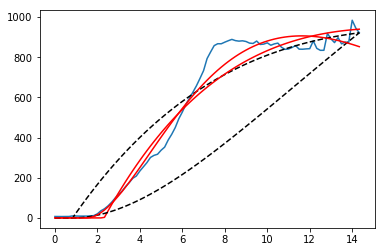

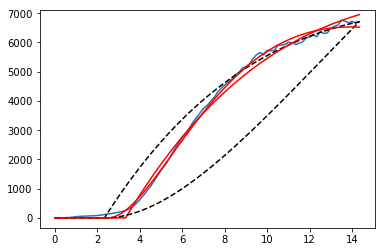

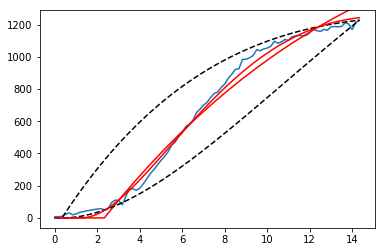

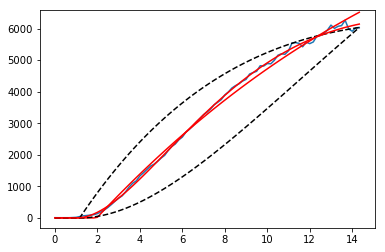

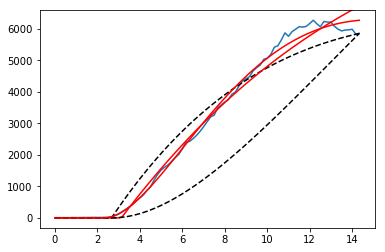

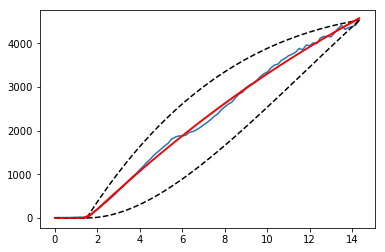

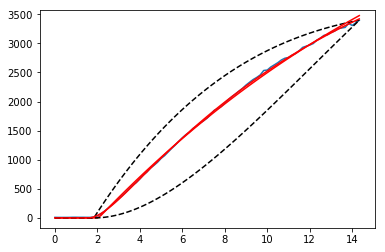

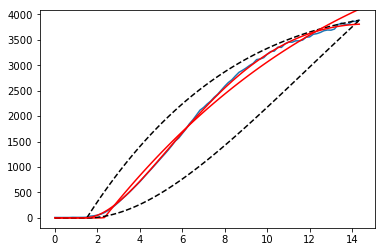

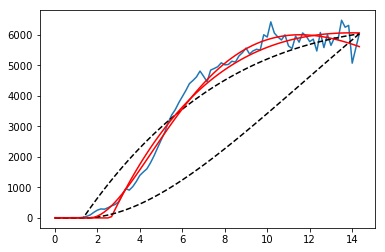

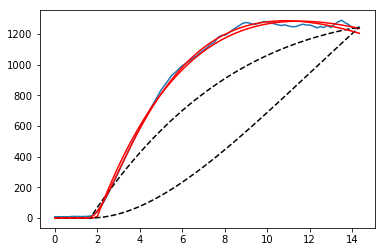

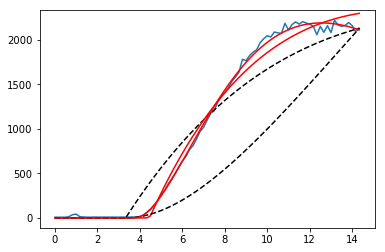

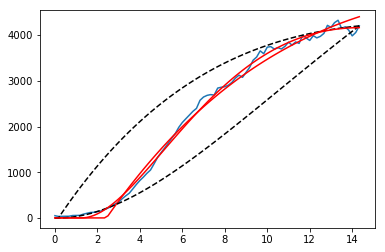

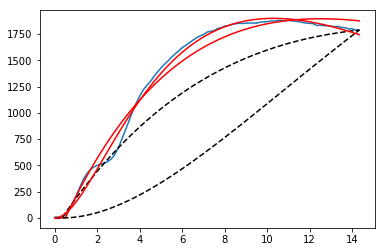

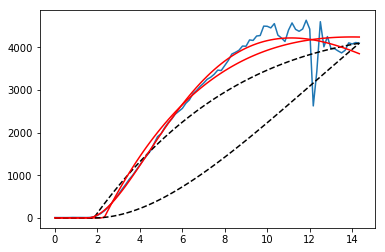

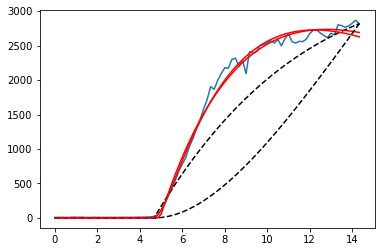

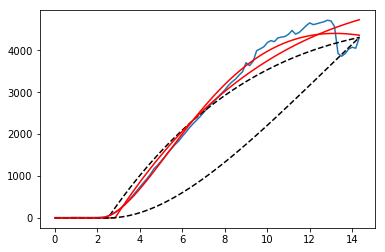

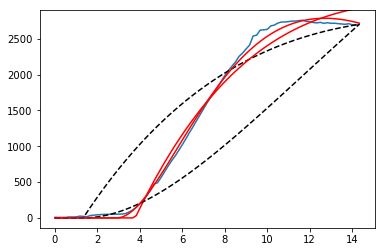

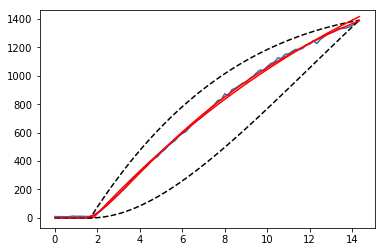

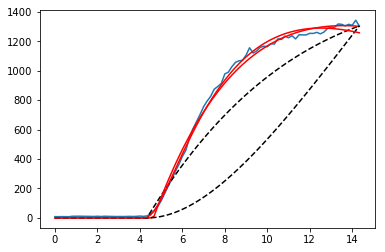

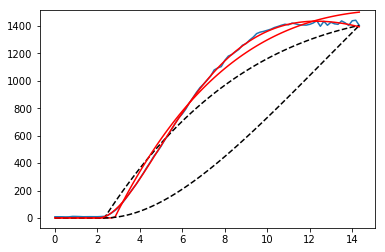

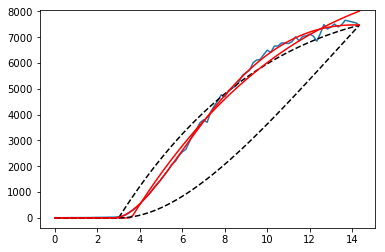

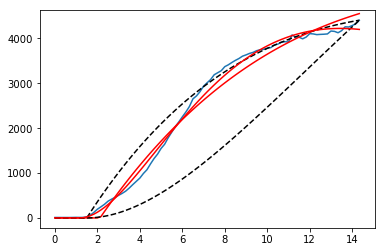

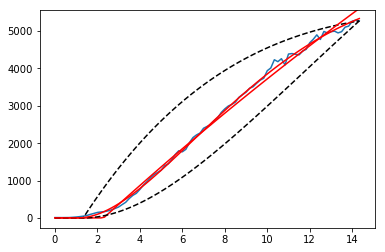

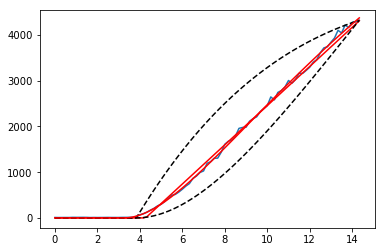

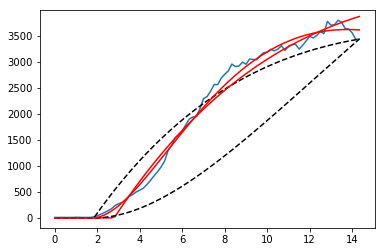

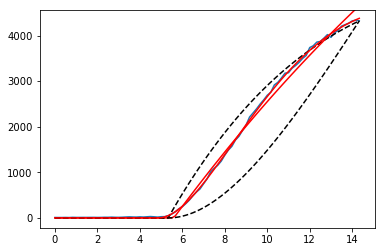

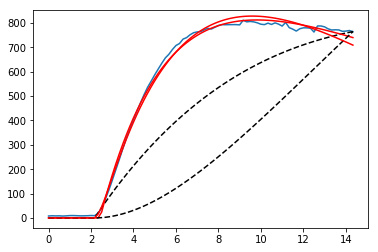

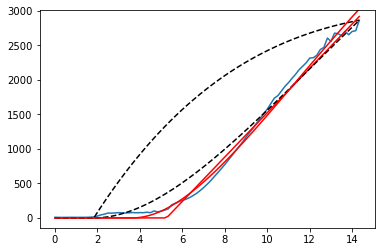

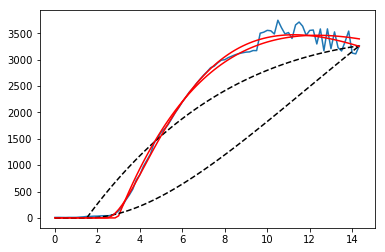

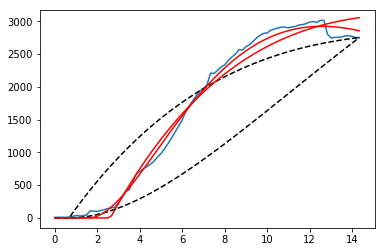

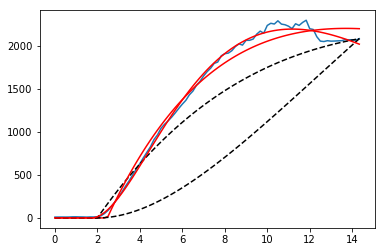

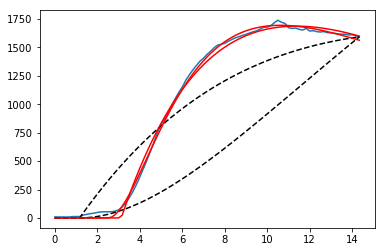

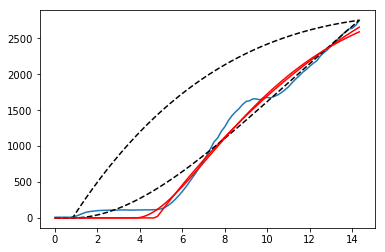

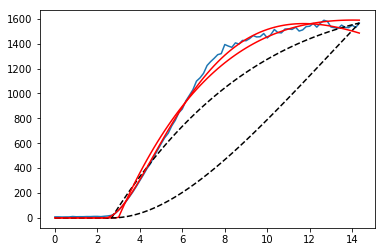

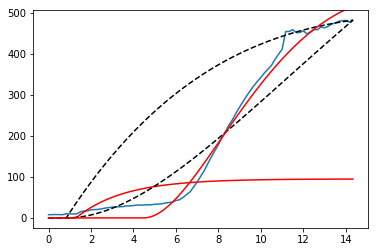

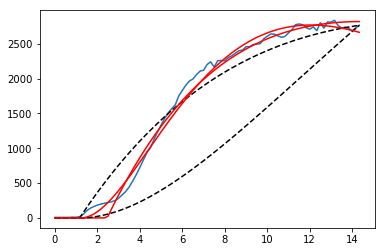

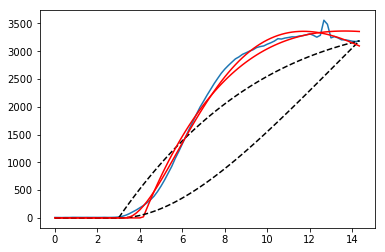

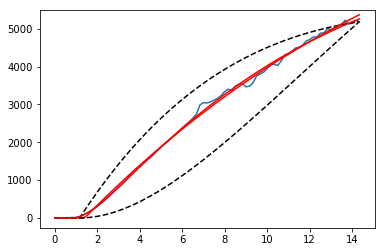

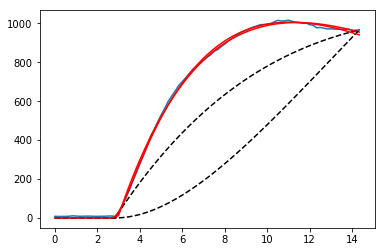

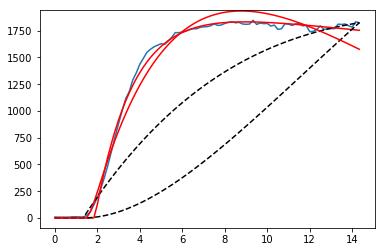

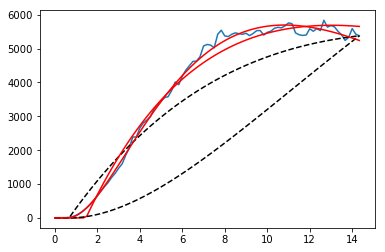

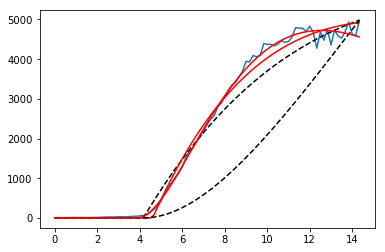

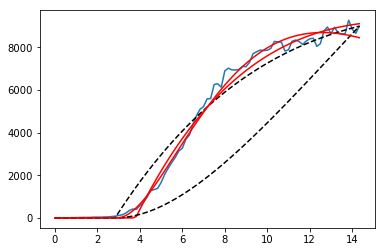

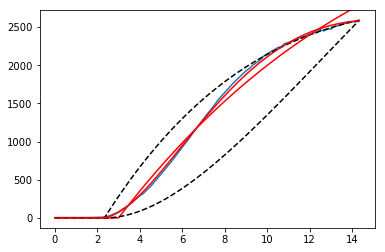

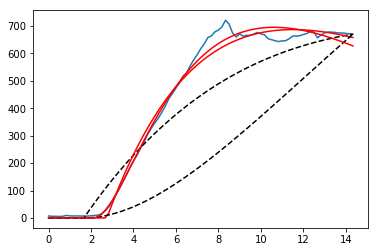

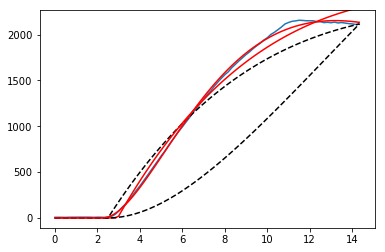

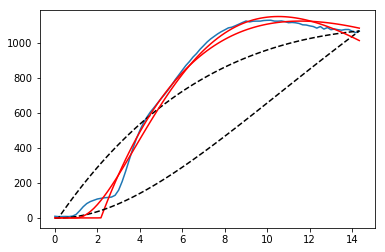

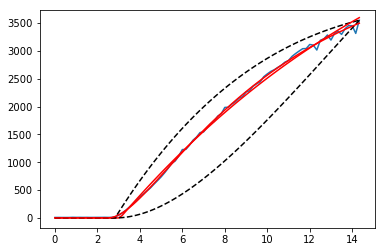

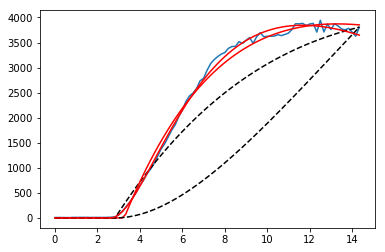

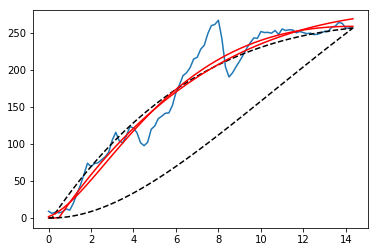

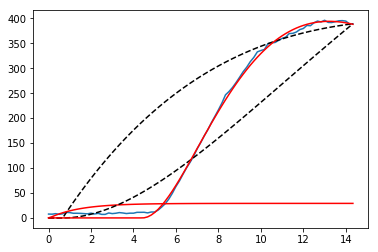

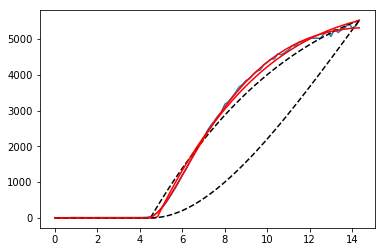

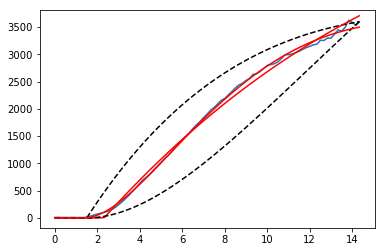

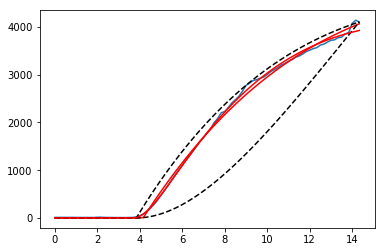

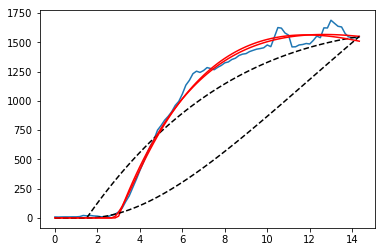

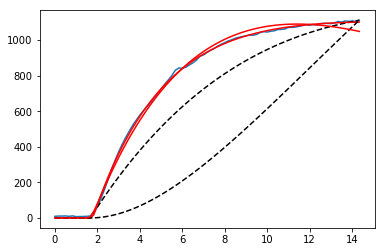

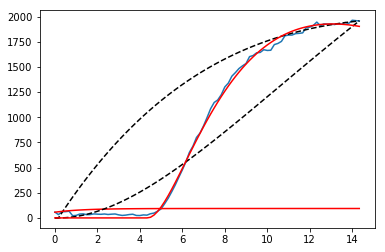

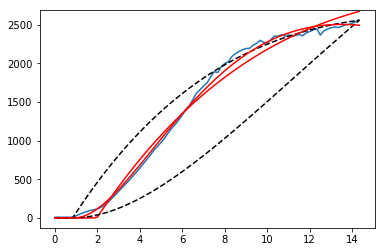

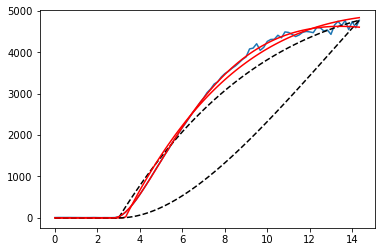

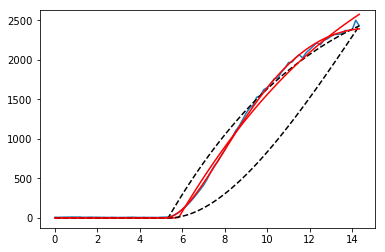

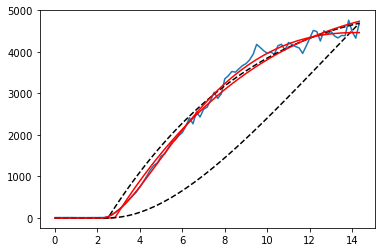

In [8]:
# two stage model
t0_list=[]
km_list=[]
delta_list=[]
beta_list=[]
t0_std_list=[]
km_std_list=[]
delta_std_list=[]
beta_std_list=[]

# three stage model
t0_list3=[]
km_list3=[]
delta_list3=[]
beta_list3=[]
t0_std_list3=[]
km_std_list3=[]
delta_std_list3=[]
beta_std_list3=[]

for data,t0guess in zip(egfp0,t0cluster_list):
    sigma = np.sqrt(data)
    time = np.arange(0,data.size)*10/60
    # lets estimate the parameters
    # we know t0 already from a cluster analysis
    delta_t=time[-1]-t0guess
    
    two=twostage(np.array([delta_t]),0,1,0.07,0.05)
    km2=data[-1]/two[0]
    
    three=threestage(np.array([delta_t]),0,1,0.07,0.05)
    km3=data[-1]/three[0]
    
    result2 = twostage_model.fit(data, t=time, t0=t0guess, km=km2, delta=0.07, beta=0.05, weights=1/sigma)
    result3 = threestage_model.fit(data, t=time, t0=t0guess, km=km3, delta=0.07, beta=0.05, weights=1/sigma)

    plt.figure()
    plt.plot(time,data)
    plt.plot(time,result2.init_fit, 'k--')
    plt.plot(time, result2.best_fit, 'r-')
    plt.plot(time,result3.init_fit, 'k--')
    plt.plot(time, result3.best_fit, 'r-')
    plt.ylim((-0.05*data.max(),data.max()*1.05))
    
    t0_list.append(result2.values['t0'])
    km_list.append(np.abs(result2.values['km']))
    delta_list.append(np.abs(result2.values['delta']))
    beta_list.append(np.abs(result2.values['beta']))

    t0_std_list.append(result2.covar[0][0])
    km_std_list.append(result2.covar[0][0])
    delta_std_list.append(result2.covar[0][0])
    beta_std_list.append(result2.covar[0][0])
    
    t0_list3.append(result3.values['t0'])
    km_list3.append(np.abs(result3.values['km']))
    delta_list3.append(np.abs(result3.values['delta']))
    beta_list3.append(np.abs(result3.values['beta']))

    t0_std_list3.append(result3.covar[0][0])
    km_std_list3.append(result3.covar[0][0])
    delta_std_list3.append(result3.covar[0][0])
    beta_std_list3.append(result3.covar[0][0])
    
t0_list=np.array(t0_list)
km_list=np.array(km_list)
delta_list=np.array(delta_list)
beta_list=np.array(beta_list)
t0_std_list=np.array(t0_std_list)
km_std_list=np.array(km_std_list)
delta_std_list=np.array(delta_std_list)
beta_std_list=np.array(beta_std_list)

t0_list3=np.array(t0_list3)
km_list3=np.array(km_list3)
delta_list3=np.array(delta_list3)
beta_list3=np.array(beta_list3)
t0_std_list3=np.array(t0_std_list3)
km_std_list3=np.array(km_std_list3)
delta_std_list3=np.array(delta_std_list3)
beta_std_list3=np.array(beta_std_list3)


{'boxes': [<matplotlib.lines.Line2D at 0x118f374a8>,
 'caps': [<matplotlib.lines.Line2D at 0x118f3cef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x118f4b7b8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x118f428d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x118f37e80>,
  <matplotlib.lines.Line2D at 0x118f51f60>]}

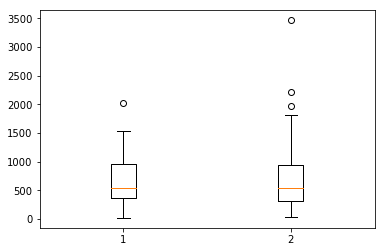

In [9]:
plt.boxplot([km_list,km_list3])

(array([ 24.,  20.,  14.,   5.,   2.,   2.,   1.,   0.,   0.,   1.]),
 array([   31.51636935,   374.9979744 ,   718.47957946,  1061.96118451,
         1405.44278956,  1748.92439461,  2092.40599966,  2435.88760471,
         2779.36920976,  3122.85081481,  3466.33241987]),
 <a list of 10 Patch objects>)

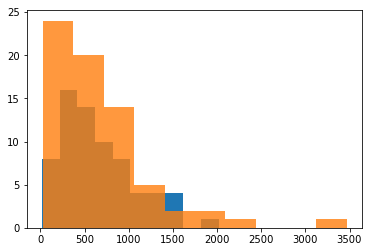

In [10]:
plt.hist(km_list,bins=10)
plt.hist(km_list3,bins=10,alpha=0.8)

{'boxes': [<matplotlib.lines.Line2D at 0x119131048>,
 'caps': [<matplotlib.lines.Line2D at 0x119135a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x11913ac88>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11913a470>,
 'whiskers': [<matplotlib.lines.Line2D at 0x119131a20>,
  <matplotlib.lines.Line2D at 0x119148ba8>]}

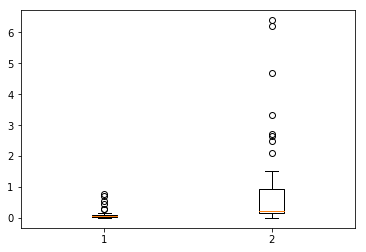

In [11]:
plt.boxplot([delta_list,delta_list3])

(array([ 46.,  13.,   2.,   2.,   2.,   1.,   0.,   1.,   0.,   2.]),
 array([  3.30878842e-07,   6.39527336e-01,   1.27905434e+00,
          1.91858135e+00,   2.55810835e+00,   3.19763536e+00,
          3.83716236e+00,   4.47668937e+00,   5.11621637e+00,
          5.75574338e+00,   6.39527038e+00]),
 <a list of 10 Patch objects>)

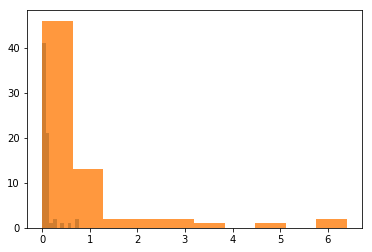

In [12]:
plt.hist(delta_list)
plt.hist(delta_list3,alpha=0.8)

{'boxes': [<matplotlib.lines.Line2D at 0x1192b7668>,
 'caps': [<matplotlib.lines.Line2D at 0x1192bffd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1192ca978>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1192c6a90>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1192b7f60>,
  <matplotlib.lines.Line2D at 0x1192d1b38>]}

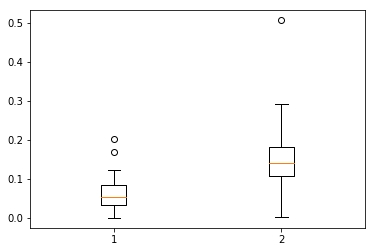

In [13]:
plt.boxplot([beta_list,beta_list3])

(array([ 11.,  12.,  18.,   8.,  10.,   7.,   1.,   0.,   1.,   1.]),
 array([  7.34642411e-08,   2.01942042e-02,   4.03883349e-02,
          6.05824656e-02,   8.07765964e-02,   1.00970727e-01,
          1.21164858e-01,   1.41358989e-01,   1.61553119e-01,
          1.81747250e-01,   2.01941381e-01]),
 <a list of 10 Patch objects>)

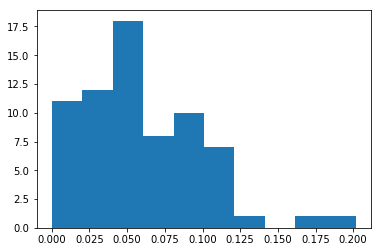

In [14]:
plt.hist(beta_list)

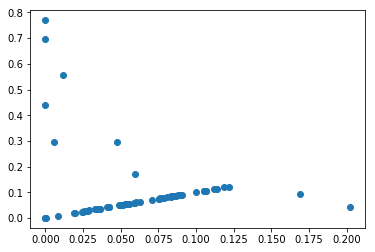

In [15]:
plt.plot(beta_list,delta_list,"o")

{'boxes': [<matplotlib.lines.Line2D at 0x1150ec8d0>],
 'caps': [<matplotlib.lines.Line2D at 0x115226be0>,
 'fliers': [<matplotlib.lines.Line2D at 0x115219f60>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x118cdd6d8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1150ec9e8>,
  <matplotlib.lines.Line2D at 0x115226240>]}

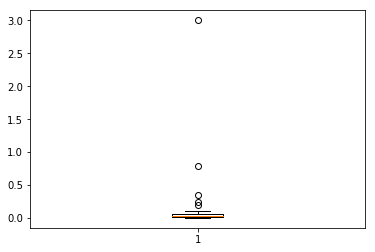

In [16]:
error_delta = delta_std_list/delta_list
error_delta_noout = error_delta[error_delta<10]
plt.boxplot(error_delta_noout)

{'boxes': [<matplotlib.lines.Line2D at 0x118af4240>,
 'caps': [<matplotlib.lines.Line2D at 0x11518b390>,
 'fliers': [<matplotlib.lines.Line2D at 0x1151b1cc0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1151b1a58>,
 'whiskers': [<matplotlib.lines.Line2D at 0x118af4d68>,
  <matplotlib.lines.Line2D at 0x1151ad470>]}

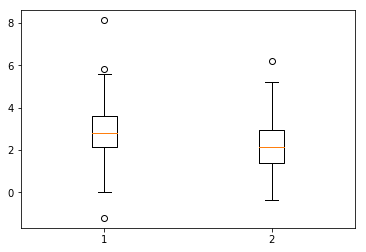

In [17]:
plt.boxplot([t0_list,t0_list3])

(array([ 10.,  13.,  15.,  13.,   9.,   2.,   4.,   2.,   0.,   1.]),
 array([ 0.16666667,  0.83333333,  1.5       ,  2.16666667,  2.83333333,
         3.5       ,  4.16666667,  4.83333333,  5.5       ,  6.16666667,
         6.83333333]),
 <a list of 10 Patch objects>)

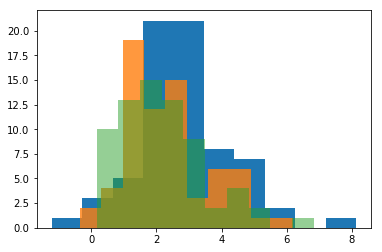

In [18]:
plt.hist(t0_list)
plt.hist(t0_list3,alpha=0.8)
plt.hist(t0cluster_list,alpha=0.5)